# Deep Convolutional WGANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

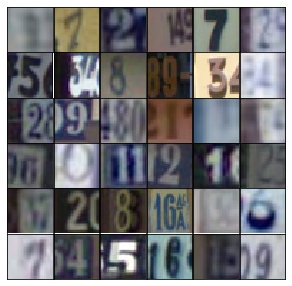

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)): # tanh
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range (-1, 1)
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [14]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, output_dim, alpha=alpha)
    Q = discriminator(input_real, alpha=alpha)
    q = discriminator(input_gen, alpha=alpha, reuse=True)
    d_loss = -tf.reduce_mean(q-Q) 
    g_loss = -tf.reduce_mean(-q)

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [16]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [17]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [18]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                if len(x) != batch_size:
                    print(batch_z.shape, x.shape)
                    
                else:
                    # Run optimizers
                    dloss, _ = sess.run([net.d_loss, net.d_opt], feed_dict={net.input_real: x, net.input_z: batch_z})
                    gloss, _ = sess.run([net.g_loss, net.g_opt], feed_dict={net.input_real: x, net.input_z: batch_z})

                    steps += 1
                    if steps % print_every == 0:
                        print("Epoch {}/{}...".format(e+1, epochs),
                              "Dloss: {:.4f}".format(dloss),
                              "Gloss: {:.4f}".format(gloss))
                        # Save losses to view after training
                        losses.append((dloss, gloss))

                    if steps % show_every == 0:
                        gen_samples = sess.run(
                                       generator(net.input_z, 3, reuse=True, training=False),
                                       feed_dict={net.input_z: sample_z})
                        samples.append(gen_samples)
                        _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                        plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [19]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 100
alpha = 0.2
beta1 = 0.5

tf.reset_default_graph()

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

Epoch 1/100... Dloss: -1.9197 Gloss: 1.5731
Epoch 1/100... Dloss: -15.3416 Gloss: 15.9113
Epoch 1/100... Dloss: -34.8282 Gloss: 26.9634
Epoch 1/100... Dloss: -55.0583 Gloss: 38.1644
Epoch 1/100... Dloss: -50.8988 Gloss: 37.3860
Epoch 1/100... Dloss: -34.8833 Gloss: 29.6248
Epoch 1/100... Dloss: -9.1756 Gloss: 17.2214
Epoch 1/100... Dloss: -27.5523 Gloss: 29.8366
Epoch 1/100... Dloss: -47.0541 Gloss: 36.5482
Epoch 1/100... Dloss: -75.8437 Gloss: 38.8103


/home/arasdar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


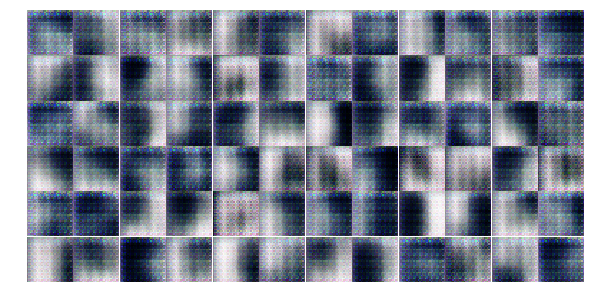

Epoch 1/100... Dloss: -86.5584 Gloss: 51.4143
Epoch 1/100... Dloss: -105.0289 Gloss: 63.4750
Epoch 1/100... Dloss: -93.9914 Gloss: 47.0474
Epoch 1/100... Dloss: -78.7662 Gloss: 42.5818
Epoch 1/100... Dloss: 1.2065 Gloss: 23.3499
Epoch 1/100... Dloss: -32.6647 Gloss: 52.4220
Epoch 1/100... Dloss: -49.8278 Gloss: 38.2350
Epoch 1/100... Dloss: -100.9371 Gloss: 54.0698
Epoch 1/100... Dloss: -17.9148 Gloss: 38.7668
Epoch 1/100... Dloss: -91.2416 Gloss: 66.2521


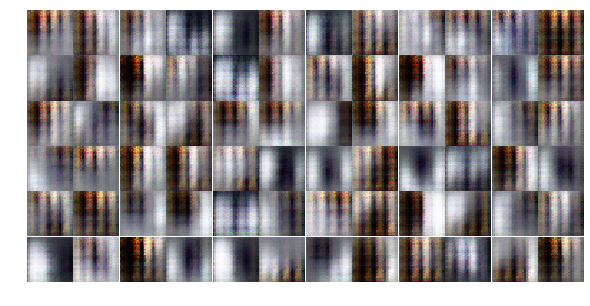

Epoch 1/100... Dloss: -32.5701 Gloss: 60.5975
Epoch 1/100... Dloss: -42.7050 Gloss: 55.6197
Epoch 1/100... Dloss: 0.0559 Gloss: 49.2622
Epoch 1/100... Dloss: -91.5450 Gloss: 69.7475
Epoch 1/100... Dloss: -125.1592 Gloss: 68.9763
Epoch 1/100... Dloss: -40.8307 Gloss: 51.0260
Epoch 1/100... Dloss: -29.5374 Gloss: 70.7056
Epoch 1/100... Dloss: -132.5662 Gloss: 77.1255
Epoch 1/100... Dloss: -149.1679 Gloss: 93.6207
Epoch 1/100... Dloss: -211.1940 Gloss: 100.9979


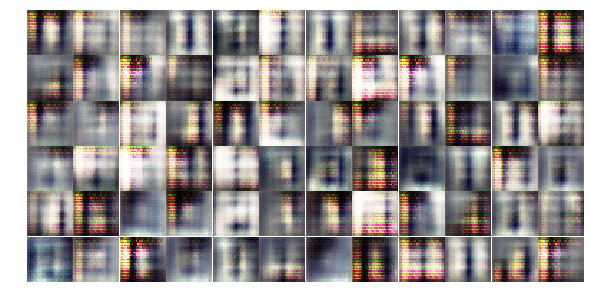

Epoch 1/100... Dloss: -182.0999 Gloss: 112.1409
Epoch 1/100... Dloss: -160.8270 Gloss: 68.6153
Epoch 1/100... Dloss: -157.7549 Gloss: 101.6367
Epoch 1/100... Dloss: -196.5016 Gloss: 133.5516
Epoch 1/100... Dloss: -127.4050 Gloss: 76.7840
Epoch 1/100... Dloss: -113.8331 Gloss: 82.1742
Epoch 1/100... Dloss: -236.0943 Gloss: 146.1725
Epoch 1/100... Dloss: -41.1084 Gloss: 93.4422
Epoch 1/100... Dloss: -110.8610 Gloss: 132.9758
Epoch 1/100... Dloss: -280.6987 Gloss: 151.1107


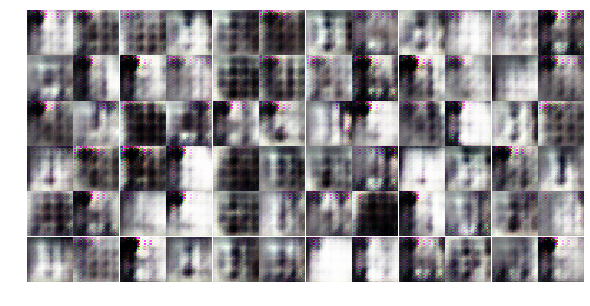

Epoch 1/100... Dloss: 11.3164 Gloss: 1.5281
Epoch 1/100... Dloss: -48.1819 Gloss: 47.4154
Epoch 1/100... Dloss: -22.8057 Gloss: 10.1511
Epoch 1/100... Dloss: -14.9819 Gloss: -136.6371
Epoch 1/100... Dloss: -30.8273 Gloss: -43.1470
Epoch 1/100... Dloss: -70.2744 Gloss: 47.5563
Epoch 1/100... Dloss: -181.4357 Gloss: 115.0918
Epoch 1/100... Dloss: -108.2210 Gloss: 157.1379
Epoch 1/100... Dloss: -99.1188 Gloss: 95.3470
Epoch 1/100... Dloss: -18.8656 Gloss: -40.4138


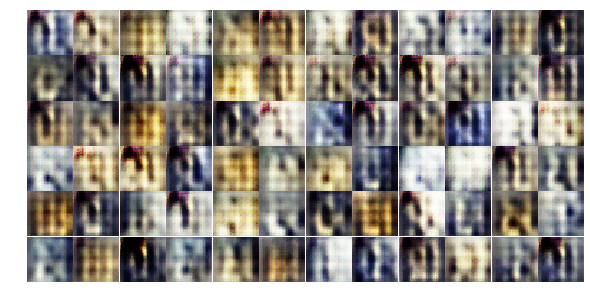

Epoch 1/100... Dloss: 30.1161 Gloss: -9.3449
Epoch 1/100... Dloss: -88.4768 Gloss: 75.5998
Epoch 1/100... Dloss: -108.3266 Gloss: 43.5280
Epoch 1/100... Dloss: -73.8168 Gloss: 84.6023
Epoch 1/100... Dloss: -102.9007 Gloss: 105.5794
Epoch 1/100... Dloss: -52.1576 Gloss: 88.3230
Epoch 1/100... Dloss: -169.1938 Gloss: 151.9503
(128, 100) (41, 32, 32, 3)
Epoch 2/100... Dloss: -78.7170 Gloss: 110.6642
Epoch 2/100... Dloss: -136.7625 Gloss: 68.8211
Epoch 2/100... Dloss: -86.7427 Gloss: 16.9107


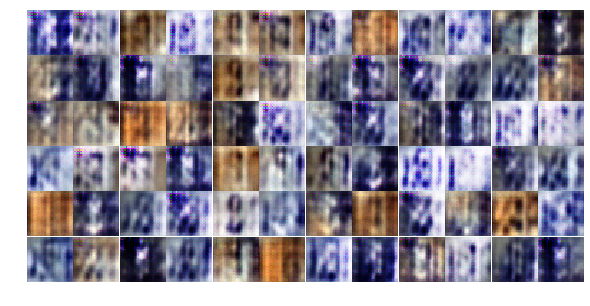

Epoch 2/100... Dloss: -129.5314 Gloss: 46.3939
Epoch 2/100... Dloss: -75.7943 Gloss: 49.3593
Epoch 2/100... Dloss: -359.0601 Gloss: 155.2029
Epoch 2/100... Dloss: -84.8176 Gloss: 118.5314
Epoch 2/100... Dloss: -223.5713 Gloss: 127.8653
Epoch 2/100... Dloss: -136.5418 Gloss: 116.9238
Epoch 2/100... Dloss: -201.2217 Gloss: 28.0039
Epoch 2/100... Dloss: -75.1413 Gloss: 60.4172
Epoch 2/100... Dloss: -101.4566 Gloss: 51.6858
Epoch 2/100... Dloss: 25.1391 Gloss: 128.2363


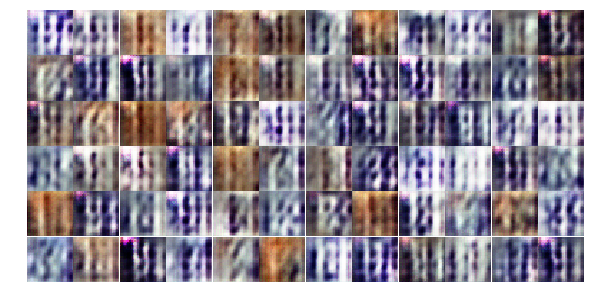

Epoch 2/100... Dloss: 53.7286 Gloss: 36.5299
Epoch 2/100... Dloss: -145.0771 Gloss: 124.6252
Epoch 2/100... Dloss: -92.2678 Gloss: 135.4091
Epoch 2/100... Dloss: -100.4354 Gloss: 69.2353
Epoch 2/100... Dloss: -131.0722 Gloss: 155.8168
Epoch 2/100... Dloss: -192.5565 Gloss: 83.9020
Epoch 2/100... Dloss: -245.6953 Gloss: 137.7161
Epoch 2/100... Dloss: -175.0059 Gloss: 143.0388
Epoch 2/100... Dloss: -18.3298 Gloss: -59.8894
Epoch 2/100... Dloss: -140.5818 Gloss: 164.2883


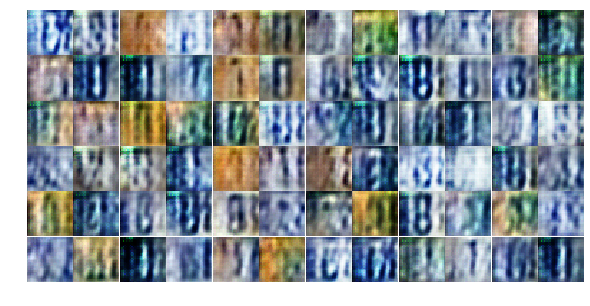

Epoch 2/100... Dloss: -235.0104 Gloss: 205.2343
Epoch 2/100... Dloss: 11.9516 Gloss: -234.1638
Epoch 2/100... Dloss: -21.4761 Gloss: -192.2599
Epoch 2/100... Dloss: -217.2197 Gloss: 190.8113
Epoch 2/100... Dloss: -278.0665 Gloss: 78.9150
Epoch 2/100... Dloss: -14.4966 Gloss: -210.5175
Epoch 2/100... Dloss: -6.3533 Gloss: -197.8901
Epoch 2/100... Dloss: -101.5645 Gloss: -76.6114
Epoch 2/100... Dloss: -132.4133 Gloss: 66.7154
Epoch 2/100... Dloss: -157.0152 Gloss: 66.7631


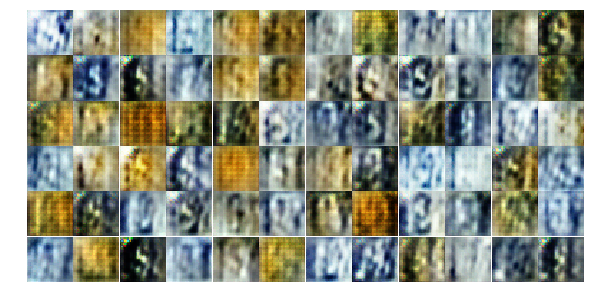

Epoch 2/100... Dloss: -170.0745 Gloss: 136.5410
Epoch 2/100... Dloss: -211.8328 Gloss: 114.7357
Epoch 2/100... Dloss: -87.0096 Gloss: 80.0245
Epoch 2/100... Dloss: -95.4610 Gloss: -77.9621
Epoch 2/100... Dloss: -62.0442 Gloss: 83.4933
Epoch 2/100... Dloss: -6.5995 Gloss: -110.4971
Epoch 2/100... Dloss: -1.5873 Gloss: -261.8047
Epoch 2/100... Dloss: -18.8580 Gloss: -228.4873
Epoch 2/100... Dloss: -114.8252 Gloss: -15.6332
Epoch 2/100... Dloss: -247.4366 Gloss: 182.3472


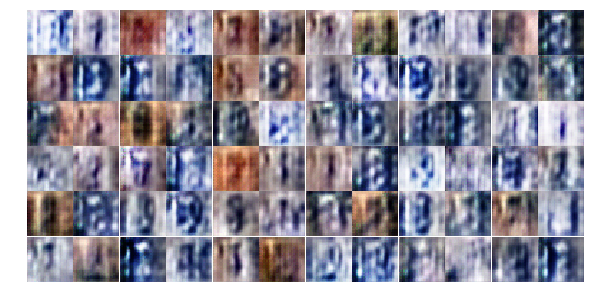

Epoch 2/100... Dloss: -173.8519 Gloss: -24.1021
Epoch 2/100... Dloss: -71.2775 Gloss: 180.1062
Epoch 2/100... Dloss: 80.8212 Gloss: 2.5021
Epoch 2/100... Dloss: 2.6976 Gloss: 114.0544
Epoch 2/100... Dloss: -50.5353 Gloss: 101.7548
Epoch 2/100... Dloss: -42.9569 Gloss: 80.5222
Epoch 2/100... Dloss: -23.8859 Gloss: 89.7822
Epoch 2/100... Dloss: 14.6017 Gloss: 146.2933
Epoch 2/100... Dloss: -73.1478 Gloss: 122.3931
Epoch 2/100... Dloss: 8.2319 Gloss: 111.5126


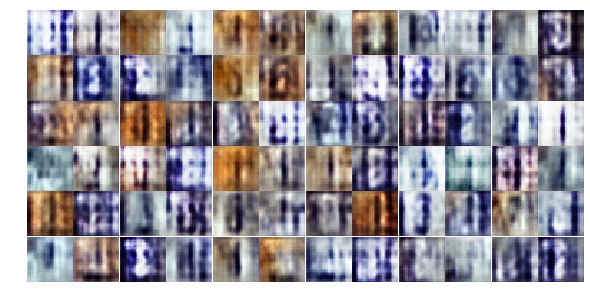

Epoch 2/100... Dloss: -30.2436 Gloss: 73.9887
Epoch 2/100... Dloss: -4.3187 Gloss: 54.9984
Epoch 2/100... Dloss: -2.6605 Gloss: 16.6274
Epoch 2/100... Dloss: 4.6477 Gloss: 37.7871
(128, 100) (41, 32, 32, 3)
Epoch 3/100... Dloss: -27.8399 Gloss: 79.0524
Epoch 3/100... Dloss: -24.7578 Gloss: 145.1812
Epoch 3/100... Dloss: -25.2045 Gloss: 108.2571
Epoch 3/100... Dloss: -26.3251 Gloss: -15.1469
Epoch 3/100... Dloss: 53.1071 Gloss: 82.4220
Epoch 3/100... Dloss: -63.2652 Gloss: 59.4291


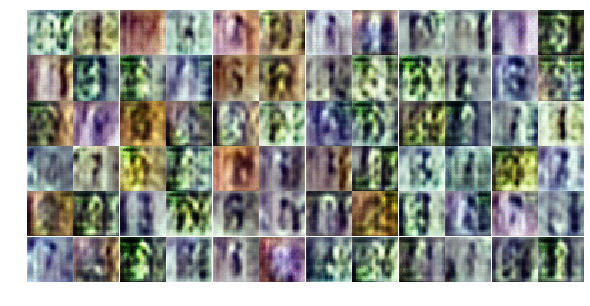

Epoch 3/100... Dloss: -12.6154 Gloss: 137.3287
Epoch 3/100... Dloss: -35.5107 Gloss: 108.8004
Epoch 3/100... Dloss: -47.0137 Gloss: 53.9317
Epoch 3/100... Dloss: -14.3289 Gloss: 48.8933
Epoch 3/100... Dloss: -25.3002 Gloss: -17.3485
Epoch 3/100... Dloss: 9.6539 Gloss: -68.0462
Epoch 3/100... Dloss: -36.2469 Gloss: 44.9031
Epoch 3/100... Dloss: -106.0795 Gloss: 117.1579
Epoch 3/100... Dloss: 1.2158 Gloss: 3.5653
Epoch 3/100... Dloss: -80.3342 Gloss: -3.6122


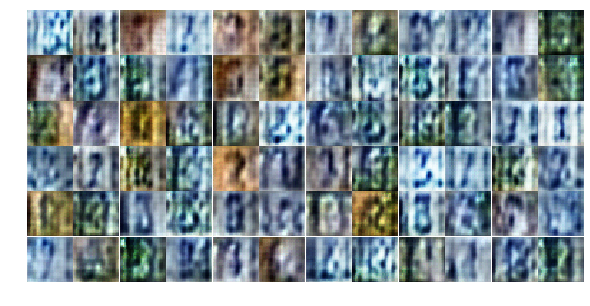

Epoch 3/100... Dloss: -4.5735 Gloss: 67.3210
Epoch 3/100... Dloss: 17.4192 Gloss: 73.6647
Epoch 3/100... Dloss: -40.9642 Gloss: 46.4284
Epoch 3/100... Dloss: -54.7947 Gloss: 106.5447
Epoch 3/100... Dloss: -28.1412 Gloss: 118.3434
Epoch 3/100... Dloss: -72.4069 Gloss: 107.0679
Epoch 3/100... Dloss: -29.6113 Gloss: 5.8184
Epoch 3/100... Dloss: -84.8416 Gloss: 49.7711
Epoch 3/100... Dloss: -6.8612 Gloss: -57.3049
Epoch 3/100... Dloss: -88.5098 Gloss: 99.1204


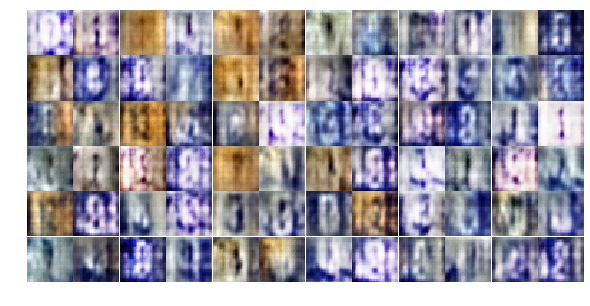

Epoch 3/100... Dloss: 19.1278 Gloss: 60.1259
Epoch 3/100... Dloss: -42.8142 Gloss: 82.2487
Epoch 3/100... Dloss: -61.0801 Gloss: 106.8238
Epoch 3/100... Dloss: 4.6737 Gloss: 98.4826
Epoch 3/100... Dloss: -27.6079 Gloss: 59.4469
Epoch 3/100... Dloss: -13.4090 Gloss: 128.7098
Epoch 3/100... Dloss: -20.5829 Gloss: 39.2326
Epoch 3/100... Dloss: -21.9718 Gloss: 57.0852
Epoch 3/100... Dloss: -62.7471 Gloss: 138.8857
Epoch 3/100... Dloss: -52.4193 Gloss: 110.0132


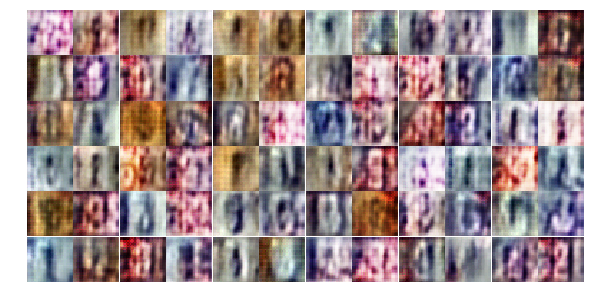

Epoch 3/100... Dloss: 37.0161 Gloss: 9.3211
Epoch 3/100... Dloss: -199.1515 Gloss: 132.5840
Epoch 3/100... Dloss: -50.1038 Gloss: -2.4267
Epoch 3/100... Dloss: 110.3787 Gloss: -197.2502
Epoch 3/100... Dloss: -17.7983 Gloss: -208.3185
Epoch 3/100... Dloss: -63.3279 Gloss: -79.6043
Epoch 3/100... Dloss: 48.2371 Gloss: -194.5907
Epoch 3/100... Dloss: -71.5094 Gloss: -50.6348
Epoch 3/100... Dloss: 87.5924 Gloss: -174.5089
Epoch 3/100... Dloss: 5.0245 Gloss: -188.9191


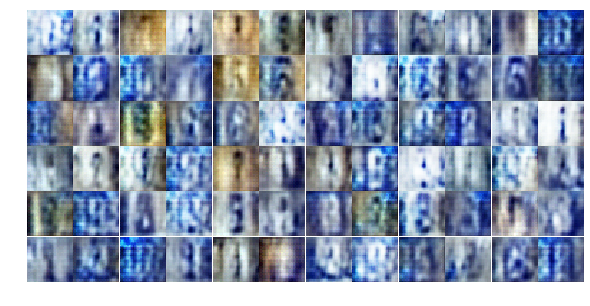

Epoch 3/100... Dloss: -72.2099 Gloss: -7.2086
Epoch 3/100... Dloss: -25.0510 Gloss: 32.2608
Epoch 3/100... Dloss: -6.5516 Gloss: 37.3145
Epoch 3/100... Dloss: -7.0596 Gloss: 28.7885
Epoch 3/100... Dloss: -5.8480 Gloss: 108.4455
Epoch 3/100... Dloss: -47.1356 Gloss: 119.7238
Epoch 3/100... Dloss: -5.0619 Gloss: 72.6786
Epoch 3/100... Dloss: -38.7195 Gloss: 90.8286
Epoch 3/100... Dloss: -18.3600 Gloss: 170.2757
Epoch 3/100... Dloss: 0.1204 Gloss: 60.6618


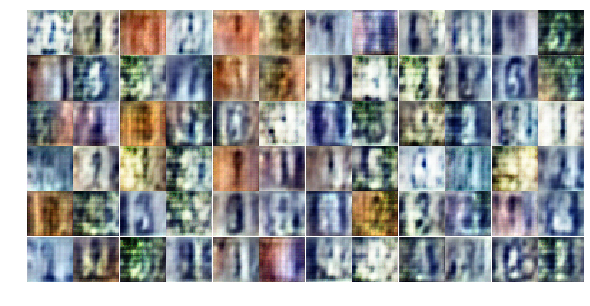

Epoch 3/100... Dloss: -31.1905 Gloss: 66.0123
(128, 100) (41, 32, 32, 3)
Epoch 4/100... Dloss: -43.3778 Gloss: 122.7546
Epoch 4/100... Dloss: -67.2391 Gloss: 166.3622
Epoch 4/100... Dloss: -108.5945 Gloss: 81.8748
Epoch 4/100... Dloss: -16.2912 Gloss: 13.8627
Epoch 4/100... Dloss: -109.8400 Gloss: 126.7372
Epoch 4/100... Dloss: -28.3881 Gloss: 143.4301
Epoch 4/100... Dloss: -133.3247 Gloss: 26.5560
Epoch 4/100... Dloss: 1.2097 Gloss: 61.8931
Epoch 4/100... Dloss: -3.4704 Gloss: 28.9479


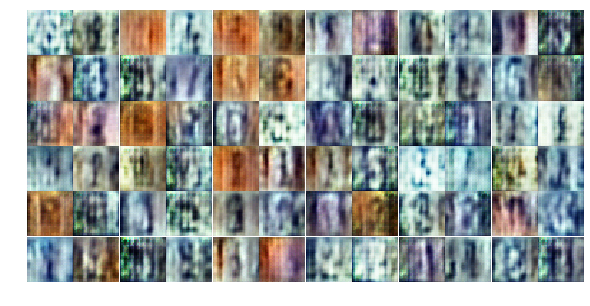

Epoch 4/100... Dloss: -22.6409 Gloss: 43.5579
Epoch 4/100... Dloss: -50.3325 Gloss: 144.9447
Epoch 4/100... Dloss: 1.6483 Gloss: 155.4299
Epoch 4/100... Dloss: -39.8992 Gloss: 145.7583
Epoch 4/100... Dloss: -27.3915 Gloss: 90.2938
Epoch 4/100... Dloss: -27.8078 Gloss: 79.2593
Epoch 4/100... Dloss: -1.1580 Gloss: 68.2065
Epoch 4/100... Dloss: -60.6909 Gloss: 163.7442
Epoch 4/100... Dloss: 29.4258 Gloss: 15.1984
Epoch 4/100... Dloss: -95.9532 Gloss: 43.1422


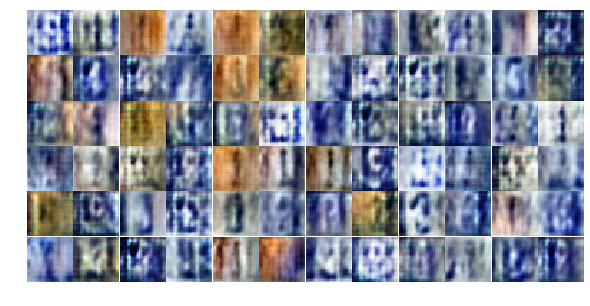

Epoch 4/100... Dloss: -86.1041 Gloss: 198.0982
Epoch 4/100... Dloss: -51.1684 Gloss: 232.3503
Epoch 4/100... Dloss: -76.0533 Gloss: 90.9999
Epoch 4/100... Dloss: -144.3668 Gloss: 213.1045
Epoch 4/100... Dloss: -127.2085 Gloss: 131.9812
Epoch 4/100... Dloss: -102.7336 Gloss: 70.5439
Epoch 4/100... Dloss: -149.5632 Gloss: 190.6257
Epoch 4/100... Dloss: 5.6114 Gloss: 69.6707
Epoch 4/100... Dloss: 42.9928 Gloss: -249.1662
Epoch 4/100... Dloss: -182.8467 Gloss: 152.5668


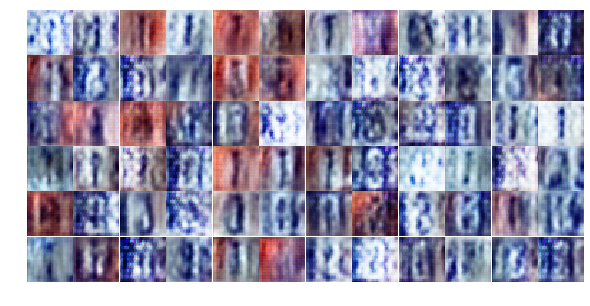

Epoch 4/100... Dloss: 190.7929 Gloss: 134.8390
Epoch 4/100... Dloss: 47.3727 Gloss: 164.1457
Epoch 4/100... Dloss: -110.5216 Gloss: 222.4021
Epoch 4/100... Dloss: 2.3590 Gloss: -210.5414
Epoch 4/100... Dloss: -53.8666 Gloss: -48.8791
Epoch 4/100... Dloss: -65.5232 Gloss: 127.0625
Epoch 4/100... Dloss: 5.4968 Gloss: 121.9076
Epoch 4/100... Dloss: -48.8569 Gloss: -84.4309
Epoch 4/100... Dloss: -212.3911 Gloss: 218.1038
Epoch 4/100... Dloss: -140.7003 Gloss: 241.2578


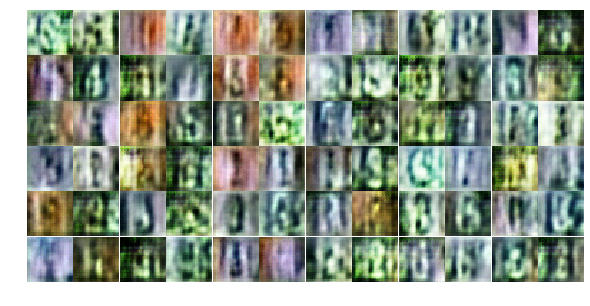

Epoch 4/100... Dloss: -243.2766 Gloss: 246.5308
Epoch 4/100... Dloss: -111.8993 Gloss: 117.2699
Epoch 4/100... Dloss: -57.4033 Gloss: -210.5376


In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

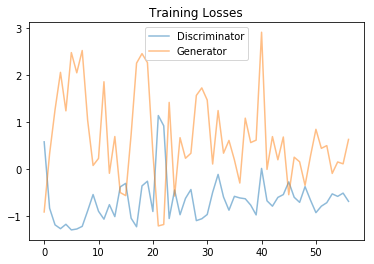

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

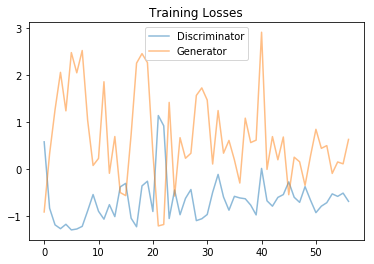

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


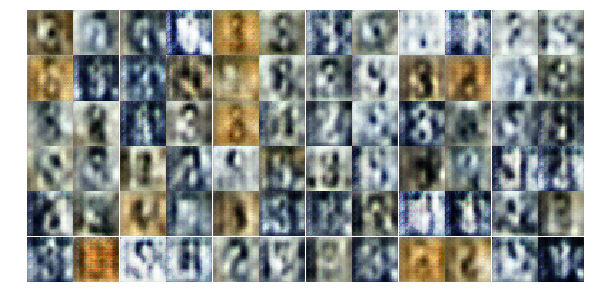

In [24]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

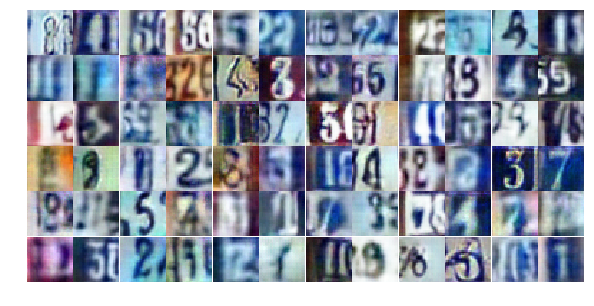

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))